In [1]:
#!pip install tensorflow==2.10

In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())



physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

['/device:CPU:0', '/device:GPU:0']
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow
from tensorflow.keras.datasets import fashion_mnist # new!
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt

In [4]:
(x_train_, y_train_), (x_valid_, y_valid_) = fashion_mnist.load_data()

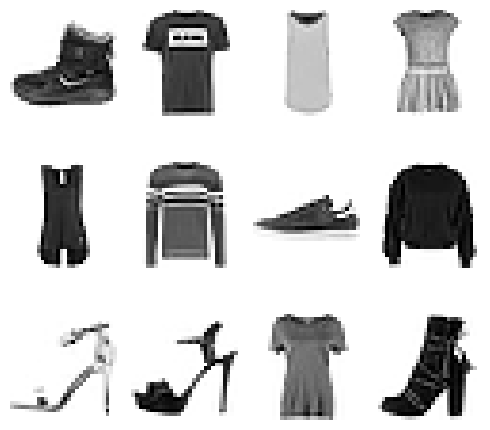

In [5]:
plt.figure(figsize=(5,5))
for k in range(12):
    plt.subplot(3, 4, k+1)
    plt.imshow(x_train_[k], cmap='Greys')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
x_train = x_train_.reshape(60000, 28, 28, 1).astype('float32')
x_valid = x_valid_.reshape(10000, 28, 28, 1).astype('float32')
x_train /= 255
x_valid /= 255
y_train = y_train_
y_valid = y_valid_

In [7]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPooling2D(strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [9]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

# Train the model
model_history = model.fit(x_train, y_train, batch_size=512, epochs=30, verbose=1, validation_data=(x_valid, y_valid), callbacks=[early_stop])

Epoch 1/30
118/118 [==============================] - 5s 19ms/step - loss: 0.7305 - accuracy: 0.7362 - val_loss: 0.5273 - val_accuracy: 0.8037
Epoch 2/30
118/118 [==============================] - 2s 16ms/step - loss: 0.4210 - accuracy: 0.8505 - val_loss: 0.3941 - val_accuracy: 0.8584
Epoch 3/30
118/118 [==============================] - 2s 16ms/step - loss: 0.3569 - accuracy: 0.8727 - val_loss: 0.3797 - val_accuracy: 0.8642
Epoch 4/30
118/118 [==============================] - 2s 17ms/step - loss: 0.3193 - accuracy: 0.8855 - val_loss: 0.3434 - val_accuracy: 0.8742
Epoch 5/30
118/118 [==============================] - 2s 17ms/step - loss: 0.2972 - accuracy: 0.8933 - val_loss: 0.3222 - val_accuracy: 0.8859
Epoch 6/30
118/118 [==============================] - 2s 17ms/step - loss: 0.2766 - accuracy: 0.9001 - val_loss: 0.3399 - val_accuracy: 0.8725
Epoch 7/30
118/118 [==============================] - 2s 17ms/step - loss: 0.2634 - accuracy: 0.9048 - val_loss: 0.3324 - val_accuracy: 0.8769

In [11]:
model.save('lenet.h5')

In [12]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'image1')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'image2')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(64, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(32, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 64)           1344        ['merge_features[1][0

In [13]:
import numpy as np

train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
test_groups = [x_valid[np.where(y_valid == i)[0]] for i in np.unique(y_train)]
print("train groups:", [x.shape[0] for x in train_groups])
print("test groups:", [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [14]:

def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

1/1 [==============================] - 0s 66ms/step


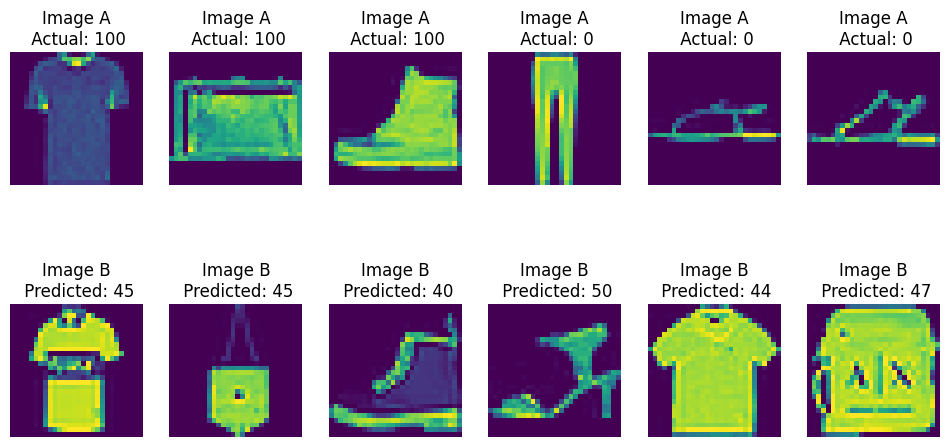

In [15]:
import matplotlib.pyplot as plt

def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [16]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 50,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 10,
    verbose = True)

1/1 [==============================] - 0s 15ms/step
Epoch 1/10
50/50 [==============================] - 6s 109ms/step - loss: 0.5626 - mae: 0.3983 - val_loss: 0.6361 - val_mae: 0.4684
Epoch 2/10
1/1 [==============================] - 0s 15ms/step


50/50 [==============================] - 5s 103ms/step - loss: 0.3004 - mae: 0.2423 - val_loss: 0.5894 - val_mae: 0.4378
Epoch 3/10
1/1 [==============================] - 0s 14ms/step


50/50 [==============================] - 5s 102ms/step - loss: 0.1962 - mae: 0.1564 - val_loss: 0.5149 - val_mae: 0.3892
Epoch 4/10
1/1 [==============================] - 0s 16ms/step


50/50 [==============================] - 5s 104ms/step - loss: 0.1596 - mae: 0.1170 - val_loss: 0.4206 - val_mae: 0.3240
Epoch 5/10
1/1 [==============================] - 0s 17ms/step


50/50 [==============================] - 5s 106ms/step - loss: 0.1143 - mae: 0.0853 - val_loss: 0.3202 - val_mae: 0.2490
Epoch 6/10
50/50 [==============================] - 5s 101ms/step - loss: 0.1126 - mae: 0.0755 - val_loss: 0.2455 - val_mae: 0.1847
Epoch 7/10
1/1 [==============================] - 0s 17ms/steploss: 0.1134 - mae: 0.07


50/50 [==============================] - 5s 106ms/step - loss: 0.1065 - mae: 0.0690 - val_loss: 0.2077 - val_mae: 0.1423
Epoch 8/10
1/1 [==============================] - 0s 14ms/step


50/50 [==============================] - 5s 105ms/step - loss: 0.0929 - mae: 0.0615 - val_loss: 0.1826 - val_mae: 0.1102
Epoch 9/10
1/1 [==============================] - 0s 15ms/step


50/50 [==============================] - 5s 101ms/step - loss: 0.1115 - mae: 0.0643 - val_loss: 0.1758 - val_mae: 0.0983
Epoch 10/10
1/1 [==============================] - 0s 34ms/step


50/50 [==============================] - 5s 104ms/step - loss: 0.0762 - mae: 0.0500 - val_loss: 0.1827 - val_mae: 0.0884


1/1 [==============================] - 0s 17ms/step


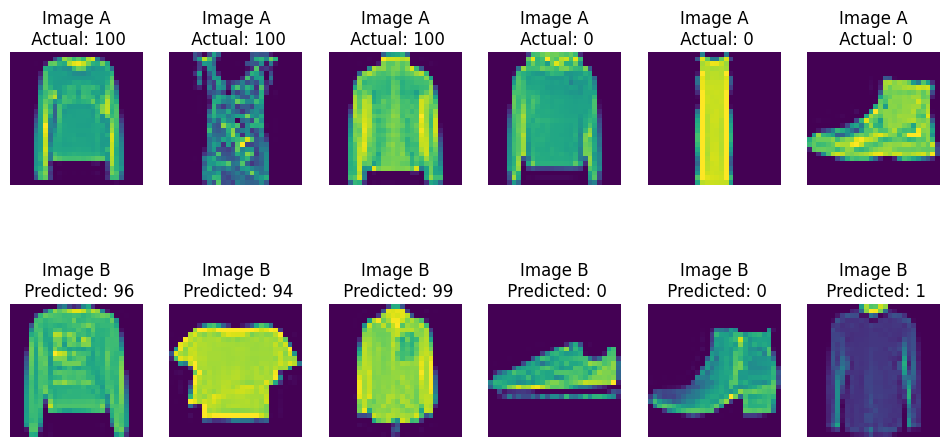

In [17]:
_ = show_model_output()

In [18]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_valid, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 0s 2ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 0.514s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.094177
[t-SNE] KL divergence afte

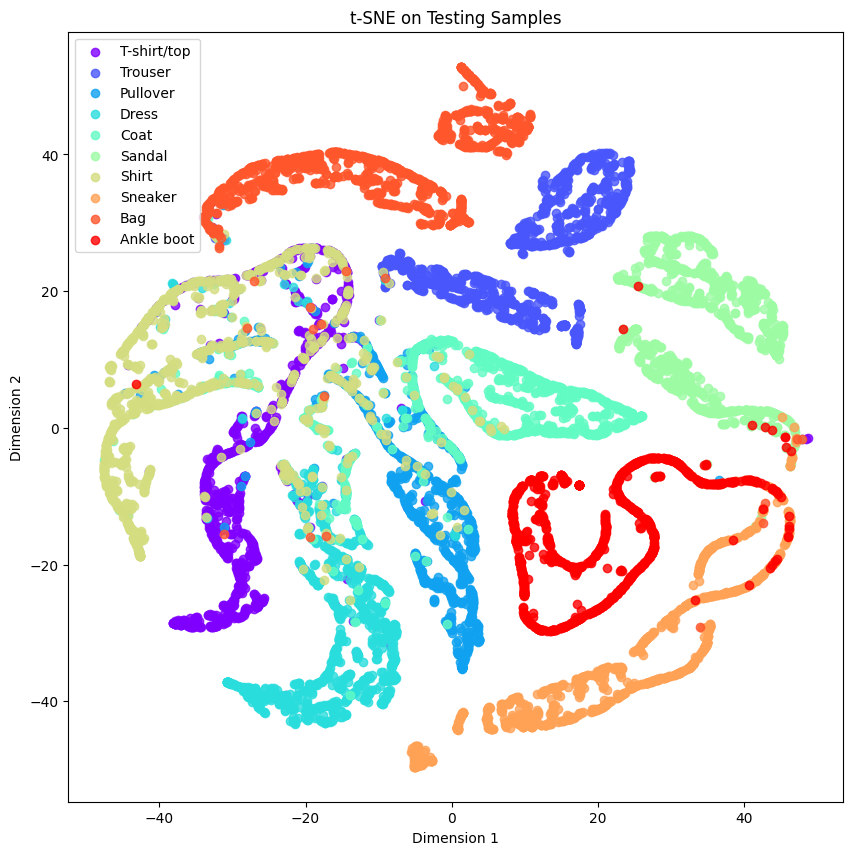

In [19]:
obj_categories = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_valid == c_group), 0],
        tsne_features[np.where(y_valid == c_group), 1],
        marker="o",
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label,
    )
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE on Testing Samples")
plt.legend(loc="best")
# plt.savefig('clothes-dist.png')
plt.show(block=False)